# Functional MRI Network Analysis using Jupyter Notebooks and Python3 on brainlife.io

This example notebook will guide the user through grabbing data for their project from the secondary warehouse, compiling data across the entire project, and analyzing and visualizing the compiled results on brainlife.io via the 'Analysis' tab. This example is written for python3, and uses one of the Python3 notebook types.

Within this notebook, I will guide the user through analyses comprising derivatives generated from one of the three main datatypes available on brainlife.io, specifically neuro/func. Specifically, I will guide the user through:
        
    1. Load sample data for local network statistics.
    2. doing some simple data manipulations
    3. generating simple visualizations
    
All of these functions used here are provided in a self-contained python package called "pybrainlife" [https://pypi.org/project/pybrainlife/].

First thing we'll do is load our python modules, specifically pandas, and pybrainlife!

### Import pandas and pybrainlife modules

In [1]:
import os,sys
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import random
from scipy.stats import ttest_ind
from example_bootstrapping_functions import bootstrap_analysis_groups,bootstrap_analysis_within_groups, plot_histogram, plot_histogram_groups, set_up_figure, create_categorical_scatterplot
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pybrainlife as pbl
from pybrainlife.data.collect import collect_data
from pybrainlife.data.collect import collect_subject_data
import pybrainlife.data.manipulate as pybldm
import pybrainlife.vis.plots as pyblvp

Next thing we'll do is we'll define some useful functions. Specifically, we will define a few fuctions to peform bootstrapping analyses on the data and plotting the histograms

### Load sample subjects data

Now that we have our modules, imported, we can load our sample datasets!

First, we will load our subjects dataframe using pandas! We will also build a column containing a color for each group.

In [3]:
### Load the subjects dataframe
## First, let's load the subjects dataframe using the collect_subject_data function in pybrainlife
## collect_subject_data():
## inputs = path where we would like to save the dataframe. if we don't want to save, just leave blank

# load the subjects data
subjects_data = collect_subject_data('subjects_data.csv')

# remove the index column just to keep things clean
subjects_data = subjects_data.drop(columns="index")

# rename the subject column to 'subjectID'
subjects_data = subjects_data.rename(columns={'subject': 'subjectID'})

# rename the diagnosis column to 'classID'
subjects_data = subjects_data.rename(columns={'diagnosis': 'classID'})

# make sure subjectID column is string
subjects_data['subjectID'] = subjects_data['subjectID'].astype(str)

### Visualize the dataframe 
## now let's visualize the dataframe to inspect
# print out a random sample of 10 rows
subjects_data.sample(10).head(10)

,subjectID,classID,age,gender,bart,bht,dwi,pamenc,pamret,rest,...,crt_ne2,crt_time1,crt_err1,crt_pr1,crt_pr2,crt_err2,crt_nm1,crt_time2,crt_nm2,crt_index
167,50061,SCHZ,48,M,1.0,1.0,1.0,1.0,1.0,1.0,...,0,49,0,0,0,0,0,86,0,0.76
190,60017,BIPOLAR,46,M,1.0,1.0,1.0,1.0,1.0,1.0,...,0,31,0,0,0,1,0,60,0,0.94
162,50055,SCHZ,23,M,1.0,1.0,1.0,1.0,1.0,1.0,...,0,30,0,0,0,0,0,62,0,1.07
64,10678,CONTROL,24,F,1.0,1.0,1.0,1.0,1.0,1.0,...,0,19,1,0,0,0,0,37,1,0.95
247,70046,ADHD,32,M,1.0,1.0,1.0,1.0,1.0,1.0,...,0,24,0,0,0,0,0,46,0,0.92
113,11088,CONTROL,21,F,1.0,1.0,1.0,1.0,1.0,1.0,...,0,23,0,0,0,0,0,57,0,1.48
77,10779,CONTROL,38,M,1.0,1.0,1.0,1.0,1.0,1.0,...,1,27,0,0,0,0,0,87,0,2.22
225,60080,BIPOLAR,29,M,1.0,1.0,1.0,1.0,1.0,1.0,...,0,28,0,0,0,0,0,72,0,1.57
44,10492,CONTROL,22,F,1.0,1.0,1.0,,,1.0,...,0,21,0,0,0,0,1,33,0,0.57
6,10225,CONTROL,35,M,1.0,1.0,1.0,,,1.0,...,0,22,0,0,0,0,1,48,0,1.18


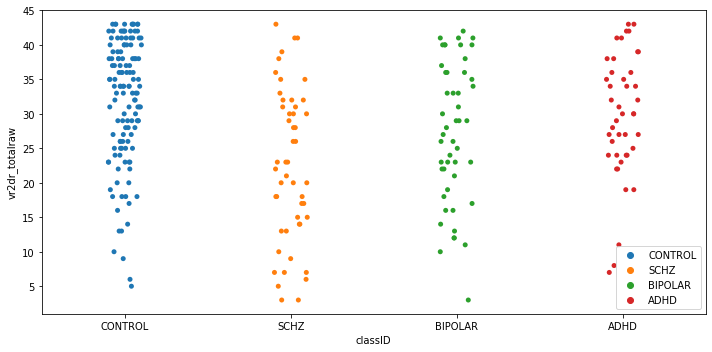

In [4]:
create_categorical_scatterplot(subjects_data,'classID','vr2dr_totalraw',hue_measure='classID')

### Local network analysis analysis
Now that we have our subjects information loaded, let's load some actual data!

For this notebook, we will load the net-stats datatype containing all of the local network statistics information for the hcp-mmp-b parcellation generated using the "collect_data" function from pybrainlife

In [5]:
## load parc-stats data
# function: collect_data()
# inputs: datatype = name of the datatype (example: 'parc-stats')
#         datatype_tags = list of datatype tags to search for (can leave blank for this analysis)
#         tags = list of object tags to search for (can leave blank for this analysis)
#         filename = name of the file within the datatype (you can search for this by using the File Viewer on the parc-stats datatype)
#         outPath = filepath where to save the concatenated data (can be left blank if you don't want to save the file)
#         duplicates = True or False; True = keep duplicates, False = remove duplicates

# set the output directory and output filename
output_filename = 'functional-local-network-statistics.csv'

# load local network statistics information
local_network_df,_,_ = collect_data(datatype='neuro/net-stats', \
                             filename='net-stats/local_measures.csv', \
                             outPath=output_filename, \
                             duplicates=True)

# make sure to set subjectID as string
local_network_df['subjectID'] = local_network_df['subjectID'].astype(str)
    
# merge subjects data frame with tractmeasures
local_network_df = local_network_df.merge(subjects_data,on='subjectID')

# reshuffle columns to be easier to read
local_network_df = local_network_df[['subjectID','classID']+[ f for f in local_network_df.keys().tolist() if f not in ['subjectID','classID']]]

# visualize the dataframe
local_network_df.sample(10).head(10)

,subjectID,classID,vertex ID,label,column_name,label_index,in_parc,Degree,Strength,ClusteringCoefficient,...,crt_ne2,crt_time1,crt_err1,crt_pr1,crt_pr2,crt_err2,crt_nm1,crt_time2,crt_nm2,crt_index
26560,50032,SCHZ,6,ROI_7,ROI_7,7,1,282,87.117374,0.777921,...,0,30,0,0,0,1,0,92,0,2.07
26215,50054,SCHZ,35,ROI_36,ROI_36,36,1,276,73.818473,0.784532,...,0,24,0,0,0,0,1,64,0,1.67
10461,10977,CONTROL,363,ROI_364,ROI_364,364,1,287,84.678692,0.791818,...,0,57,1,1,0,0,0,101,0,0.77
35223,50055,SCHZ,67,ROI_68,ROI_68,68,1,309,102.664366,0.769806,...,0,30,0,0,0,0,0,62,0,1.07
21227,10345,CONTROL,283,ROI_284,ROI_284,284,1,291,94.244860,0.795947,...,0,43,0,0,1,0,0,98,0,1.28
12704,10565,CONTROL,362,ROI_363,ROI_363,363,1,305,106.889327,0.780522,...,0,28,0,0,0,0,0,65,0,1.32
13377,11131,CONTROL,287,ROI_288,ROI_288,288,1,307,102.274314,0.798748,...,0,44,0,0,0,0,1,68,0,0.55
25031,10527,CONTROL,347,ROI_348,ROI_348,348,1,254,68.924924,0.778687,...,0,24,0,0,0,2,1,59,0,1.46
13349,11131,CONTROL,259,ROI_260,ROI_260,260,1,282,77.226809,0.800888,...,0,44,0,0,0,0,1,68,0,0.55
13421,11131,CONTROL,331,ROI_332,ROI_332,332,1,317,109.849960,0.798407,...,0,44,0,0,0,0,1,68,0,0.55


# Describe the dataframe

#### compute mean, min-max, and quantiles of each column using pandas function describe()

In [8]:
local_network_df.describe()

,vertex ID,label_index,in_parc,Degree,Strength,ClusteringCoefficient,Coreness,BetweenessCentrality,BetweenessCentralityWeighted,sessionID,...,crt_ne2,crt_time1,crt_err1,crt_pr1,crt_pr2,crt_err2,crt_nm1,crt_time2,crt_nm2,crt_index
count,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000,36278.0,...,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000
mean,186.500000,187.500000,0.998704,286.892772,91.367704,0.777072,243.939771,42.570483,135.220685,1.0,...,0.020619,37.783505,0.123711,0.082474,0.195876,0.288660,0.309278,73.670103,0.082474,1.107526
std,107.965602,107.965602,0.035971,21.669621,17.418911,0.033747,9.645083,5.630425,79.957351,0.0,...,0.142106,18.243865,0.329256,0.310312,0.510499,0.672882,0.631825,25.909684,0.310312,0.630744
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,...,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,0.000000,-0.140000
25%,93.000000,94.000000,1.000000,275.000000,79.189318,0.766551,242.000000,39.150495,77.000000,1.0,...,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,58.000000,0.000000,0.670000
50%,186.500000,187.500000,1.000000,288.000000,89.815151,0.776685,244.000000,42.762199,120.000000,1.0,...,0.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000,1.030000
75%,280.000000,281.000000,1.000000,301.000000,102.118682,0.789308,247.000000,46.253176,176.000000,1.0,...,0.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,87.000000,0.000000,1.380000
max,373.000000,374.000000,1.000000,348.000000,182.827476,0.870165,255.000000,65.182256,700.000000,1.0,...,1.000000,126.000000,1.000000,2.000000,3.000000,3.000000,4.000000,201.000000,2.000000,3.180000


#### compute meta data on the dataframe using pandas function info()

In [9]:
local_network_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36278 entries, 0 to 36277
Columns: 169 entries, subjectID to colors
dtypes: float64(61), int64(72), object(36)
memory usage: 47.1+ MB


#### count the number of parcels for each subject. ideal value == 360

In [10]:
local_network_df.groupby('subjectID').count()

,classID,vertex ID,label,column_name,label_index,in_parc,Degree,Strength,ClusteringCoefficient,Coreness,...,crt_time1,crt_err1,crt_pr1,crt_pr2,crt_err2,crt_nm1,crt_time2,crt_nm2,crt_index,colors
subjectID,,,,,,,,,,,,,,,,,,,,,
10159,374,374,374,374,374,374,374,374,374,374,...,374,374,374,374,374,374,374,374,374,374
10171,374,374,374,374,374,374,374,374,374,374,...,374,374,374,374,374,374,374,374,374,374
10189,374,374,374,374,374,374,374,374,374,374,...,374,374,374,374,374,374,374,374,374,374
10228,374,374,374,374,374,374,374,374,374,374,...,374,374,374,374,374,374,374,374,374,374
10290,374,374,374,374,374,374,374,374,374,374,...,374,374,374,374,374,374,374,374,374,374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50077,374,374,374,374,374,374,374,374,374,374,...,374,374,374,374,374,374,374,374,374,374
50080,374,374,374,374,374,374,374,374,374,374,...,374,374,374,374,374,374,374,374,374,374
50081,374,374,374,374,374,374,374,374,374,374,...,374,374,374,374,374,374,374,374,374,374


#### count the number of unique subjects per group

In [11]:
local_network_df.groupby(['subjectID','classID']).mean().reset_index().groupby(['classID']).count()['subjectID']

classID
CONTROL    50
SCHZ       47
Name: subjectID, dtype: int64

#### subsample to only the primary visual cortex (V1)

In [10]:
# grab the v1's from the dataframe
regions = ['ROI_1','ROI_195']
v1 = local_network_df.loc[local_network_df['label'].isin(regions)]
v1['structureID'] = [ 'lh.v1' if f == 'ROI_1' else 'rh.v1' for f in v1['label'] ]

v1.sample(10).head(10)

,subjectID,classID,vertex ID,label,column_name,label_index,in_parc,Degree,Strength,ClusteringCoefficient,...,crt_time1,crt_err1,crt_pr1,crt_pr2,crt_err2,crt_nm1,crt_time2,crt_nm2,crt_index,structureID
17398,50027,SCHZ,194,ROI_195,ROI_195,195,1,311,117.370358,0.804273,...,27,0,0,0,0,0,57,0,1.11,rh.v1
194,10438,CONTROL,194,ROI_195,ROI_195,195,1,277,79.262460,0.764689,...,31,0,0,0,0,0,73,0,1.35,rh.v1
16082,10696,CONTROL,0,ROI_1,ROI_1,1,1,317,116.371927,0.798986,...,25,0,0,0,1,0,71,0,1.84,lh.v1
19642,10228,CONTROL,194,ROI_195,ROI_195,195,1,290,89.055709,0.738480,...,21,0,0,0,0,0,50,1,1.38,rh.v1
3186,50035,SCHZ,194,ROI_195,ROI_195,195,1,272,83.559068,0.772194,...,54,0,0,2,0,0,145,0,1.69,rh.v1
13838,50066,SCHZ,0,ROI_1,ROI_1,1,1,317,117.025690,0.772811,...,24,0,0,0,0,0,54,0,1.25,lh.v1
30114,11104,CONTROL,194,ROI_195,ROI_195,195,1,295,98.934360,0.775487,...,23,0,0,0,0,0,39,0,0.70,rh.v1
23562,10891,CONTROL,0,ROI_1,ROI_1,1,1,276,81.500780,0.767167,...,32,0,0,0,0,0,72,0,1.25,lh.v1
22814,50047,SCHZ,0,ROI_1,ROI_1,1,1,296,84.402349,0.753985,...,124,0,2,3,3,0,201,0,0.62,lh.v1
5430,10934,CONTROL,194,ROI_195,ROI_195,195,1,293,89.211969,0.768549,...,56,0,0,1,1,1,140,0,1.50,rh.v1


#### compute mean across hemispheres

In [11]:
v1_mean = v1.groupby(['subjectID','classID']).mean().reset_index()
v1_mean

,subjectID,classID,vertex ID,label_index,in_parc,Degree,Strength,ClusteringCoefficient,Coreness,BetweenessCentrality,...,crt_ne2,crt_time1,crt_err1,crt_pr1,crt_pr2,crt_err2,crt_nm1,crt_time2,crt_nm2,crt_index
0,10159,CONTROL,97.0,98.0,1.0,279.5,91.431935,0.797796,247.0,35.433649,...,0.0,32.0,0.0,0.0,0.0,0.0,1.0,59.0,0.0,0.84
1,10171,CONTROL,97.0,98.0,1.0,289.0,97.962861,0.791201,249.0,39.286218,...,0.0,51.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,0.10
2,10189,CONTROL,97.0,98.0,1.0,296.5,99.318303,0.773804,242.0,46.704606,...,0.0,22.0,0.0,0.0,0.0,0.0,1.0,51.0,0.0,1.32
3,10228,CONTROL,97.0,98.0,1.0,277.5,79.374344,0.736350,238.0,51.551163,...,0.0,21.0,0.0,0.0,0.0,0.0,0.0,50.0,1.0,1.38
4,10290,CONTROL,97.0,98.0,1.0,267.0,81.095279,0.777403,250.0,36.421678,...,0.0,26.0,0.0,0.0,0.0,0.0,1.0,58.0,0.0,1.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,50077,SCHZ,97.0,98.0,1.0,283.0,89.003252,0.772642,246.0,42.917249,...,0.0,42.0,0.0,0.0,0.0,0.0,0.0,87.0,0.0,1.07
93,50080,SCHZ,97.0,98.0,1.0,268.5,79.033756,0.784435,242.0,36.126598,...,0.0,44.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,0.77
94,50081,SCHZ,97.0,98.0,1.0,284.5,96.345093,0.775139,245.0,42.311540,...,0.0,28.0,0.0,0.0,0.0,1.0,0.0,88.0,0.0,2.14
95,50083,SCHZ,97.0,98.0,1.0,288.5,85.295203,0.764447,243.0,46.751129,...,0.0,42.0,1.0,0.0,0.0,2.0,1.0,86.0,0.0,1.05


### Data visualizations

Now, let's generate some visualizations to examine differences between groups across multiple brain and behavior measures

#### v1 functional measures

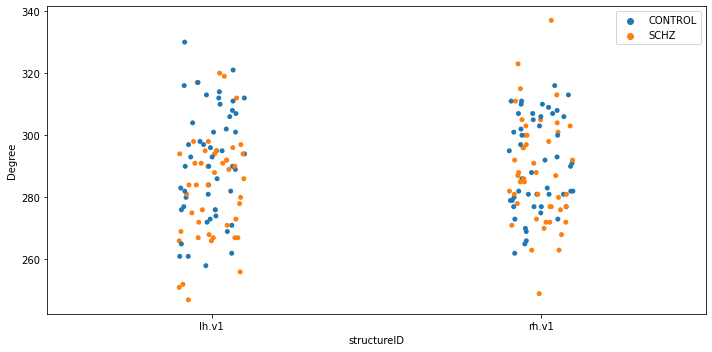

In [12]:
# create categorical scatterplot of gray matter volume of left and right hemisphere
create_categorical_scatterplot(v1,'structureID','Degree',hue_measure='classID')


# ## compute categorical scatter plot for the left and right V1s for gray matter volume and cortical thickness
# # create a subplot figure with 1 row and 2 columns
# fig, axes = plt.subplots(1,2,figsize=(10,5),sharex=True)

# # create a strip plot for each measure
# sns.stripplot(x='classID',y='Degree',data=v1,hue='classID',palette=groups_colors,ax=axes[0],size=5,legend=False)
# sns.stripplot(x='classID',y='Coreness',data=v1,hue='classID',palette=groups_colors,ax=axes[1],size=5)
# fig.tight_layout()

Next let's plot a histogram to visualize the distributions for each of groups of interest!

<Axes: xlabel='Degree', ylabel='Count'>

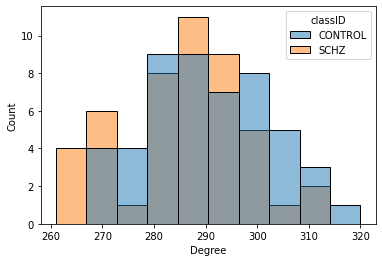

In [14]:
# generate a histogram for each group for the v42dr_totalraw measure
sns.histplot(x='Degree',hue='classID',data=v1_mean,bins=10)

Finally let's see if we can identify a linear relationship between functional connectivity of V1 and a behavior!

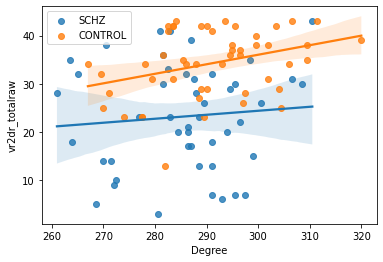

In [15]:
# separate dataframe for each group
schz = v1_mean.loc[v1_mean['classID'] == 'SCHZ']
control = v1_mean.loc[v1_mean['classID'] == 'CONTROL']

fig = plt.figure()
axes = plt.gca()
sns.regplot(x='Degree',y='vr2dr_totalraw',data=schz,label='SCHZ')
sns.regplot(x='Degree',y='vr2dr_totalraw',data=control,label='CONTROL')
plt.legend()

Let's look overall across groups!

<Axes: xlabel='Degree', ylabel='vr2dr_totalraw'>

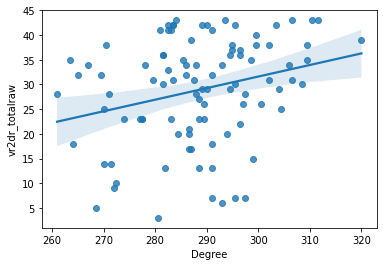

In [17]:
# create a linear regression plot for the overall data between variables of interest
sns.regplot(x='Degree',y='vr2dr_totalraw',data=v1_mean)

## You've now completed your first set of analyses on brainlife.io using the jupyter notebooks!